In [13]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [14]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [15]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [16]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [17]:
label_map = {6:0, 7:1, 8:2, 9:3}
class_names = ['frog', 'horse','ship','truck']
cifar2 = [(img, label_map[label])
          for img, label in cifar10 
          if label in [6,7,8,9]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [6,7,8,9]]

In [18]:
import torch.nn as nn

n_out = 2

model = nn.Sequential(
            nn.Linear(
                3072,  # <1>
                512,   # <2>
            ),
            nn.Tanh(),
            nn.Linear(
                512,   # <2>
                n_out, # <3>
            )
        )

In [19]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [20]:
x = torch.tensor([1.0, 2.0, 3.0])

softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [21]:
softmax(x).sum()

tensor(1.)

In [22]:
softmax = nn.Softmax(dim=1)

x = torch.tensor([[1.0, 2.0, 3.0],
                  [1.0, 2.0, 3.0]])

softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [23]:
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.Softmax(dim=1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


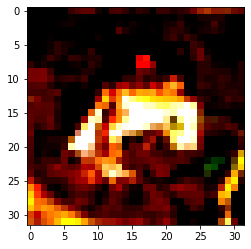

In [24]:
img, _ = cifar2[0]

plt.imshow(img.permute(1, 2, 0))
plt.show()

In [25]:
img_batch = img.view(-1).unsqueeze(0)

In [26]:
out = model(img_batch)
out

tensor([[0.4813, 0.5187]], grad_fn=<SoftmaxBackward>)

In [27]:
_, index = torch.max(out, dim=1)

index

tensor([1])

In [28]:
out = torch.tensor([
    [0.6, 0.4],
    [0.9, 0.1],
    [0.3, 0.7],
    [0.2, 0.8],
])
class_index = torch.tensor([0, 0, 1, 1]).unsqueeze(1)

truth = torch.zeros((4,2))
truth.scatter_(dim=1, index=class_index, value=1.0)
truth

tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.]])

In [29]:
def mse(out):
    return ((out - truth) ** 2).sum(dim=1).mean()
mse(out)

tensor(0.1500)

In [30]:
out.gather(dim=1, index=class_index)

tensor([[0.6000],
        [0.9000],
        [0.7000],
        [0.8000]])

In [31]:
def likelihood(out):
    prod = 1.0
    for x in out.gather(dim=1, index=class_index):
        prod *= x
    return prod

likelihood(out)

tensor([0.3024])

In [32]:
def neg_log_likelihood(out):
    return -likelihood(out).log()

neg_log_likelihood(out)

tensor([1.1960])

In [33]:
out0 = out.clone().detach()
out0[0] = torch.tensor([0.9, 0.1]) # more right

out2 = out.clone().detach()
out2[0] = torch.tensor([0.4, 0.6]) # slightly wrong

out3 = out.clone().detach()
out3[0] = torch.tensor([0.1, 0.9]) # very wrong

mse_comparison = torch.tensor([mse(o) for o in [out0, out, out2, out3]])
mse_comparison

tensor([0.0750, 0.1500, 0.2500, 0.4750])

In [34]:
((mse_comparison / mse_comparison[1]) - 1) * 100

tensor([-50.0000,   0.0000,  66.6667, 216.6667])

In [35]:
nll_comparison = torch.tensor([neg_log_likelihood(o) 
                               for o in [out0, out, out2, out3]])
nll_comparison

tensor([0.7905, 1.1960, 1.6015, 2.9878])

In [36]:
((nll_comparison / nll_comparison[1]) - 1) * 100

tensor([-33.9016,   0.0000,  33.9016, 149.8121])

In [37]:
softmax = nn.Softmax(dim=1)

log_softmax = nn.LogSoftmax(dim=1)

x = torch.tensor([[0.0, 104.0]])

softmax(x)

tensor([[0., 1.]])

In [38]:
softmax = nn.Softmax(dim=1)

log_softmax = nn.LogSoftmax(dim=1)

x = torch.tensor([[0.0, 104.0]])

softmax(x)

tensor([[0., 1.]])

In [39]:
torch.log(softmax(x))

tensor([[-inf, 0.]])

In [40]:
log_softmax(x)

tensor([[-104.,    0.]])

In [41]:
torch.exp(log_softmax(x))

tensor([[0., 1.]])

In [42]:
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

In [43]:
loss = nn.NLLLoss()

In [44]:
img, label = cifar2[0]

out = model(img.view(-1).unsqueeze(0))

loss(out, torch.tensor([label]))

tensor(0.8378, grad_fn=<NllLossBackward>)

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim

model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 4),
            nn.LogSoftmax(dim=1))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 200

for epoch in range(n_epochs):
    for img, label in cifar2:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))
                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

/home/jslowik/my_project_dir/my_project_env/lib/python3.8/site-packages/torch/autograd/__init__.py:145: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(


Epoch: 0, Loss: 1.243082
Epoch: 1, Loss: 0.548146
Epoch: 2, Loss: 0.932015
Epoch: 3, Loss: 0.169997
Epoch: 4, Loss: 0.315956
Epoch: 5, Loss: 2.439218
Epoch: 6, Loss: 0.141258
Epoch: 7, Loss: 0.061503
Epoch: 8, Loss: 0.578588
Epoch: 9, Loss: 0.107993
Epoch: 10, Loss: 0.697367
Epoch: 11, Loss: 0.551811
Epoch: 12, Loss: 0.079274
Epoch: 13, Loss: 0.618779
Epoch: 14, Loss: 0.438550
Epoch: 15, Loss: 0.189376
Epoch: 16, Loss: 0.081803
Epoch: 17, Loss: 0.011746
Epoch: 18, Loss: 0.059550
Epoch: 19, Loss: 0.162876
Epoch: 20, Loss: 0.168925
Epoch: 21, Loss: 0.190359
Epoch: 22, Loss: 0.009904
Epoch: 23, Loss: 0.034636
Epoch: 24, Loss: 0.097111
Epoch: 25, Loss: 0.932584
Epoch: 26, Loss: 0.024422
Epoch: 27, Loss: 0.124040
Epoch: 28, Loss: 0.415125
Epoch: 29, Loss: 0.919839
Epoch: 30, Loss: 0.006476
Epoch: 31, Loss: 0.008057
Epoch: 32, Loss: 0.012759
Epoch: 33, Loss: 0.009646
Epoch: 34, Loss: 0.015655
Epoch: 35, Loss: 0.031573
Epoch: 36, Loss: 0.003182
Epoch: 37, Loss: 0.012605
Epoch: 38, Loss: 0.007

In [46]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 128),
            nn.Tanh(),
            nn.Linear(128, 4),
            nn.LogSoftmax(dim=1))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.747161
Epoch: 1, Loss: 0.597091
Epoch: 2, Loss: 0.843865
Epoch: 3, Loss: 0.723263
Epoch: 4, Loss: 0.852786
Epoch: 5, Loss: 0.654204
Epoch: 6, Loss: 0.641875
Epoch: 7, Loss: 0.627172
Epoch: 8, Loss: 0.717173
Epoch: 9, Loss: 0.422885
Epoch: 10, Loss: 0.427043
Epoch: 11, Loss: 0.525573
Epoch: 12, Loss: 0.414445
Epoch: 13, Loss: 0.547417
Epoch: 14, Loss: 0.779358
Epoch: 15, Loss: 0.506499
Epoch: 16, Loss: 0.788995
Epoch: 17, Loss: 0.596254
Epoch: 18, Loss: 0.337827
Epoch: 19, Loss: 0.469661
Epoch: 20, Loss: 0.338278
Epoch: 21, Loss: 0.443974
Epoch: 22, Loss: 0.230342
Epoch: 23, Loss: 0.350829
Epoch: 24, Loss: 0.370630
Epoch: 25, Loss: 0.506468
Epoch: 26, Loss: 0.343951
Epoch: 27, Loss: 0.178061
Epoch: 28, Loss: 0.221187
Epoch: 29, Loss: 0.299355
Epoch: 30, Loss: 0.346360
Epoch: 31, Loss: 0.199286
Epoch: 32, Loss: 0.231356
Epoch: 33, Loss: 0.262224
Epoch: 34, Loss: 0.217820
Epoch: 35, Loss: 0.091862
Epoch: 36, Loss: 0.239234
Epoch: 37, Loss: 0.212719
Epoch: 38, Loss: 0.211

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 4),
            nn.LogSoftmax(dim=1))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.698913
Epoch: 1, Loss: 0.563975
Epoch: 2, Loss: 0.843531
Epoch: 3, Loss: 0.948495
Epoch: 4, Loss: 0.906816
Epoch: 5, Loss: 0.524139
Epoch: 6, Loss: 0.750646
Epoch: 7, Loss: 0.546581
Epoch: 8, Loss: 0.525565
Epoch: 9, Loss: 0.452217
Epoch: 10, Loss: 0.673746
Epoch: 11, Loss: 0.453285
Epoch: 12, Loss: 0.398217
Epoch: 13, Loss: 0.472489
Epoch: 14, Loss: 0.602265
Epoch: 15, Loss: 0.629979
Epoch: 16, Loss: 0.580442
Epoch: 17, Loss: 0.237232
Epoch: 18, Loss: 0.521063
Epoch: 19, Loss: 0.513679
Epoch: 20, Loss: 0.251487
Epoch: 21, Loss: 0.347835
Epoch: 22, Loss: 0.550319
Epoch: 23, Loss: 0.220483
Epoch: 24, Loss: 0.300832
Epoch: 25, Loss: 0.489581
Epoch: 26, Loss: 0.288087
Epoch: 27, Loss: 0.135026
Epoch: 28, Loss: 0.208802
Epoch: 29, Loss: 0.291663
Epoch: 30, Loss: 0.275132
Epoch: 31, Loss: 0.194159
Epoch: 32, Loss: 0.093949
Epoch: 33, Loss: 0.143653
Epoch: 34, Loss: 0.297038
Epoch: 35, Loss: 0.084638
Epoch: 36, Loss: 0.072860
Epoch: 37, Loss: 0.073930
Epoch: 38, Loss: 0.114

In [49]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.999950


In [50]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.777000


In [51]:
model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2),
            nn.LogSoftmax(dim=1))

In [52]:
model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

loss_fn = nn.CrossEntropyLoss()

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 4))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.823026
Epoch: 1, Loss: 0.638058
Epoch: 2, Loss: 0.660956
Epoch: 3, Loss: 0.640689
Epoch: 4, Loss: 0.619317
Epoch: 5, Loss: 0.630605
Epoch: 6, Loss: 0.631297
Epoch: 7, Loss: 0.568022
Epoch: 8, Loss: 0.553457
Epoch: 9, Loss: 0.526853
Epoch: 10, Loss: 0.449107
Epoch: 11, Loss: 0.628612
Epoch: 12, Loss: 0.390994
Epoch: 13, Loss: 0.704763
Epoch: 14, Loss: 0.469556
Epoch: 15, Loss: 0.545955
Epoch: 16, Loss: 0.427177
Epoch: 17, Loss: 0.545322
Epoch: 18, Loss: 0.243450
Epoch: 19, Loss: 0.343227
Epoch: 20, Loss: 0.328343
Epoch: 21, Loss: 0.204442
Epoch: 22, Loss: 0.151440
Epoch: 23, Loss: 0.109108
Epoch: 24, Loss: 0.350829
Epoch: 25, Loss: 0.067646
Epoch: 26, Loss: 0.100494
Epoch: 27, Loss: 0.180961
Epoch: 28, Loss: 0.204179
Epoch: 29, Loss: 0.031449
Epoch: 30, Loss: 0.164447
Epoch: 31, Loss: 0.033213
Epoch: 32, Loss: 0.029114
Epoch: 33, Loss: 0.032837
Epoch: 34, Loss: 0.027520
Epoch: 35, Loss: 0.016238
Epoch: 36, Loss: 0.028401
Epoch: 37, Loss: 0.016852
Epoch: 38, Loss: 0.005

In [54]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 1.000000


In [55]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.764000


In [56]:
sum([p.numel() for p in model.parameters()])

3737732

In [57]:
sum([p.numel() for p in model.parameters() if p.requires_grad == True])

3737732

In [58]:
first_model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))

sum([p.numel() for p in first_model.parameters()])

1574402

In [59]:
sum([p.numel() for p in nn.Linear(3072, 512).parameters()])

1573376

In [60]:
sum([p.numel() for p in nn.Linear(3072, 1024).parameters()])

3146752

In [61]:
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

In [62]:
conv = nn.Conv2d(3, 16, kernel_size=3)

In [63]:
conv.weight.shape

torch.Size([16, 3, 3, 3])

In [64]:
conv.bias.shape

torch.Size([16])

In [65]:
img, _ = cifar2[0]

output = conv(img.unsqueeze(0))

In [66]:
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


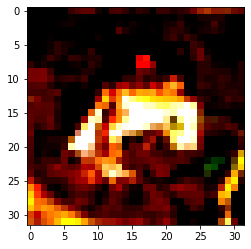

In [67]:
plt.imshow(img.permute(1, 2, 0), cmap='gray')
plt.show()

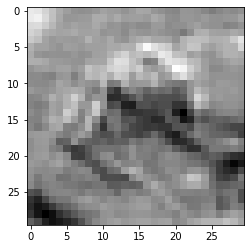

In [68]:
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [69]:
output.shape

torch.Size([1, 16, 30, 30])

In [70]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

In [71]:
output = conv(img.unsqueeze(0))

output.shape

torch.Size([1, 1, 32, 32])

In [72]:
with torch.no_grad():
    conv.bias.zero_()

In [73]:
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

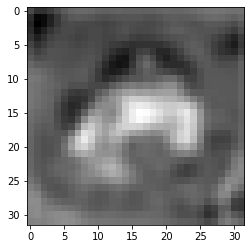

In [74]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [75]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

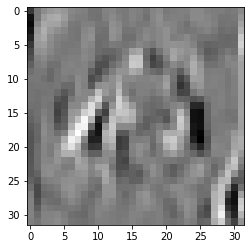

In [76]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [77]:
pool = nn.MaxPool2d(2)

In [78]:
output = pool(img.unsqueeze(0))

output.shape

torch.Size([1, 3, 16, 16])